In [1]:
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms

from test_model import test_model
from train_model import train_model

%matplotlib inline

In [2]:
if torch.cuda.is_available():
    device = "cuda:0"
elif torch.backends.mps.is_built():
    device = torch.device("mps")
else:
    device = "cpu"

In [4]:
data_dir = "tiny-224/"
num_workers = {"train": 2, "val": 2, "test": 0}
# Definir sequência de transformação para pré-processamento de imagem
# Se não estiver usando o modelo pré-treinado, normalize com 0,5, 0,5, 0,5 (média e DP)
# Se estiver usando ImageNet pré-treinado normalize com:
# mean = [0,4802, 0,4481, 0,3975], std=[0.2302, 0.2265, 0.2262]
data_transforms = {
    "train": transforms.Compose(
        [
            transforms.RandomRotation(20),
            transforms.RandomHorizontalFlip(0.5),
            transforms.ToTensor(),
            transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262]),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262]),
        ]
    ),
    "test": transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262]),
        ]
    ),
}
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ["train", "val", "test"]
}
dataloaders = {
    x: data.DataLoader(image_datasets[x], batch_size=100, shuffle=True, num_workers=num_workers[x])
    for x in ["train", "val", "test"]
}

In [9]:
# Carregar a rede Resnet18
torch.manual_seed(42)
model_ft = models.resnet18(weights="IMAGENET1K_V1")

model_ft.relu = nn.GELU()
# Ajuste fino das poucas camadas finais para ajustar a pequena entrada do imagenet
model_ft.avgpool = nn.AdaptiveAvgPool2d(1)
num_features = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_features, 200)
model_ft = model_ft.to(device)

# Função de perda
criterion = nn.CrossEntropyLoss()
# Observe que todos os parâmetros estão sendo otimizados
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

In [10]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): GELU(approximate='none')
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=Tr

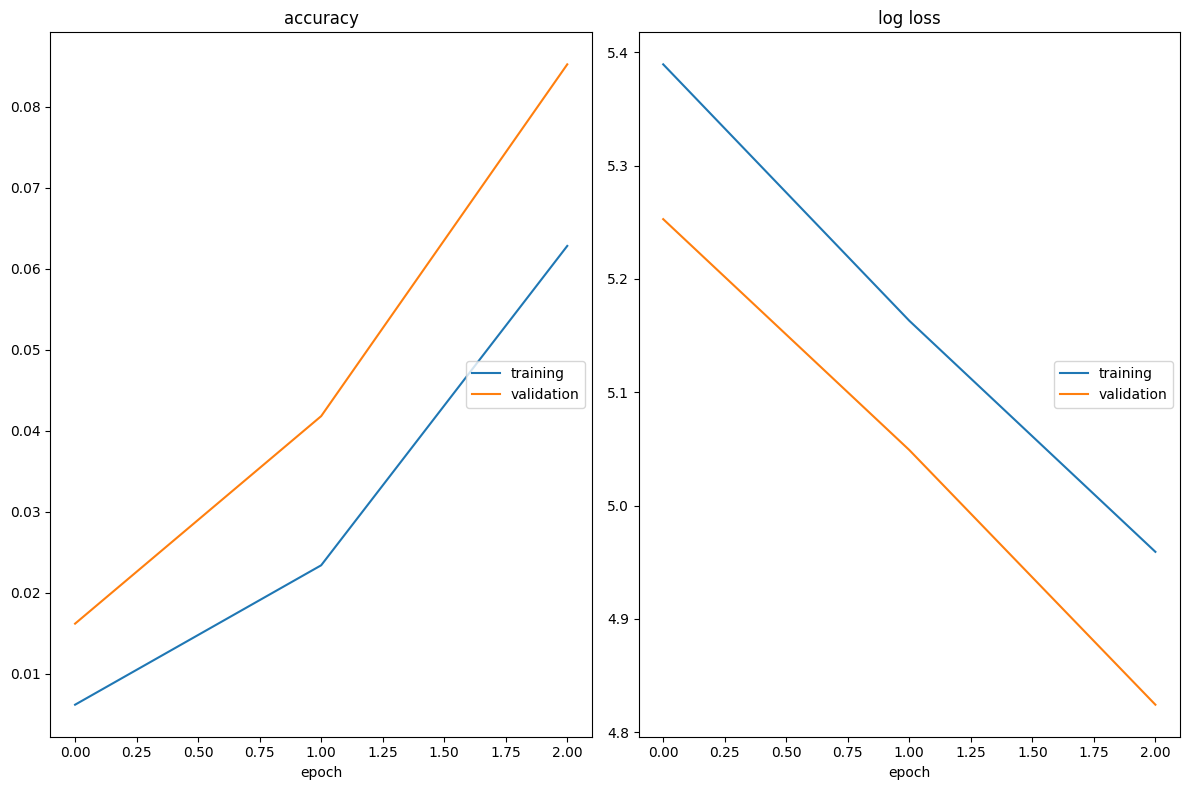

accuracy
	training         	 (min:    0.006, max:    0.063, cur:    0.063)
	validation       	 (min:    0.016, max:    0.085, cur:    0.085)
log loss
	training         	 (min:    4.959, max:    5.389, cur:    4.959)
	validation       	 (min:    4.824, max:    5.253, cur:    4.824)
Training complete in 20m 16s
Best Validation Accuracy: 0.0851999968290329, Epoch: 3


In [5]:
# Train
best_epoch = train_model(
    output_path="RestNet18_224",
    model=model_ft,
    dataloaders=dataloaders,
    criterion=criterion,
    optimizer=optimizer_ft,
    device=device,
    num_epochs=3,
)

In [6]:
# Test
model_ft.load_state_dict(torch.load(f"models/RestNet18_224/model_{best_epoch}_epoch.pt"))
test_model(model=model_ft, dataloaders=dataloaders, criterion=criterion, device=device)

Test Loss: 4.9473 Acc: 0.0536
Test complete in 1m 37s
